# QRS Detector

This notebook implements the actual QRS Detector. In this notebook there are two networks present, a fully conected feed forward network and a recurrent network, with the aim of comparing the two models and verifying which is more indicated for the type of data we have

In [0]:
# importing required libraries
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import pickle as pkl
import random
import math

#!pip install wfdb
import wfdb
from wfdb.processing import find_local_peaks
from wfdb.processing import compare_annotations

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
from glob import glob

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This part describes the location of the data files. The processed data files shoud be placed in a folder inside google Drive and the path for that folder shoud be specified in `main_path`

In [3]:
!ls drive/'My Drive'/'Colab Notebooks'/processed_data
main_path = 'drive/My Drive/Colab Notebooks/processed_data/'
weights_path = 'drive/My Drive/Colab Notebooks/network_weights/'

Test  Training


## Sampling Function

The objective is to retrieve a random cropping of both the signal and the target from all files specified for the training/validation set. This helps us have a more well-versed dataset for training and validating our models.

In [0]:
# auxiliary function
# extracts from a long np-array (2-rows) a (2-rows)-random segment with a fixed length (seqL*ninputs)
def selectFrom1ecg(ecgBdata, seqL, ninputs, feed_forward = True, training = True, testing = False):
    """
    x: An array with vairous files, channels and examples
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    file_indexes: A list of the file indexes for training or validation set
    """
    segmentL  = seqL * ninputs
    numChan = 3
    
    if(training):
        random_file_idx = random.randint(0, 57)
    else:
        random_file_idx = random.randint(0, 9)
    
    if(testing):
        random_file_idx = random.randint(0, 48)
    
    inpOutSegment = tf.random_crop(ecgBdata[random_file_idx],[numChan, segmentL])

    
    if(feed_forward):
        channelII = inpOutSegment[0,:]
        channelV1 = inpOutSegment[1,:]
        target = inpOutSegment[2,:]
        inputs = tf.concat((channelII, channelV1), axis = -1)
        return inputs,target
    else:
        transposed = tf.transpose(inpOutSegment)
        
        inputs = transposed[:, :-1]
        target = transposed[:, -1]
        inputs = tf.reshape(inputs, (seqL, -1))
        
        # We need to re-transpose the target to turn int back into a one-row vector
        target = tf.transpose(target)
                
        return inputs, target

## Dataset array creation

In this section we create the main dataset array containing all the training files. Each file has two input signals (channelII and channelV1) and a target signal.

In [0]:
dataset_array = []

files_not_to_read = [4,17,35,44,57,72,74]
index_counter = 0
for i in range(1, 76):
    
    if i not in files_not_to_read:
        file_path = f"Training/I{i:02}"
        file_path = main_path + file_path
        file_data = pkl.load(open(file_path, "rb"))        
        index_counter = index_counter + 1
        
        info = [file_data["channelII"], file_data["channelV1"], file_data["label"]]
        info = np.array(info)
        info = info.astype(np.float32)
        dataset_array.append(info)

ecgs_array = np.array(dataset_array)

### Parameters for networks

In [6]:
# Sampling frequency
fs = 360

# For each timestep we give ninputs
ninputs = int(0.2*fs)

# Sequence length (number of timesteps)
seqL = int((5 * 360)/ninputs) # Using a 5 second window sequence


print('FFWD network parameters')
print('ninputs = ',ninputs)
print('seqL = ',seqL)
print('ninputs*seqL = ',ninputs*seqL)

seql_rnn = 3 * seqL

print(" ")
print('RNN network parameters')
print('ninputs = ',ninputs)
print('seqL(rnn) = ',seql_rnn)
print('ninputs*seqL(rnn) = ',ninputs*seql_rnn)



FFWD network parameters
ninputs =  72
seqL =  25
ninputs*seqL =  1800
 
RNN network parameters
ninputs =  72
seqL(rnn) =  75
ninputs*seqL(rnn) =  5400


## Test dataset array creation

In this section we create the test dataset array containing all the test files. Each file has two input signals ("MLII","V1", which correspond to signals "II" and "V1" in the training dataset) and a target signal.

In [0]:
test_dataset_array = []

files_not_to_read = [110, 120, 204, 206, 211, 216, 218, 229]
files_not_to_read = files_not_to_read + list(range(125,200)) + list(range(224,228))

index_counter = 0
for i in range(100, 235):
    
    if i not in files_not_to_read:
        file_path = f"Test/{i}"
        file_path = main_path + file_path
        file_data = pkl.load(open(file_path, "rb"))        
        index_counter = index_counter + 1
        
        info = [file_data["channelII"], file_data["channelV1"], file_data["label"]]
        info = np.array(info)
        info = info.astype(np.float32)
        test_dataset_array.append(info)

test_ecgs_array = np.array(test_dataset_array)

# Test dataset length is not a multiple of 2*ninputs*seqL(rnn) which causes problems when we want to
# transpose the data as before, so we discard the last 2000 points 
# The test dataset will then have the same length as the training dataset
lenRecords = test_ecgs_array.shape[2]
new_length = int(math.floor(lenRecords/(ninputs*seql_rnn))*(ninputs*seql_rnn))
test_ecgs_array = test_ecgs_array[:,:,:new_length]

In [8]:
# number of examples
N = ecgs_array.shape[2]

# training data for feed forward network
# Create efficient training sequences
trainData = tf.data.Dataset.from_tensors(ecgs_array[:len(ecgs_array) - 10, :, :])
trainData = trainData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training = True))
trainData = trainData.repeat()  # Repeat the input indefinitely.
batchSize = 8
trainData = trainData.batch(batchSize)

valData = tf.data.Dataset.from_tensors(ecgs_array[len(ecgs_array) - 10:, :, :])
valData = valData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training = False))
valData = valData.repeat()  # Repeat the input indefinitely.
batchSize = 8
valData = valData.batch(batchSize)

# test data for feed forward network (here we don't need to leave out the 10 files)
testData = tf.data.Dataset.from_tensors(test_ecgs_array)
testData = testData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training = False, testing = True))
testData = testData.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData = testData.batch(batchSize)


# Creating Training and Validation datasets with the correct shape for a Recurrent neural network
# The sequence length for the recurrent neural network can be about 3 times greater than for the feed
# forward neural net


trainData_rnn = tf.data.Dataset.from_tensors(ecgs_array[:len(ecgs_array) - 10, :, :])
trainData_rnn = trainData_rnn.map(lambda x:  selectFrom1ecg(x, seql_rnn, ninputs, training = True, feed_forward = False))
trainData_rnn = trainData_rnn.repeat()  # Repeat the input indefinitely.
batchSize_rnn = 8
trainData_rnn = trainData_rnn.batch(batchSize_rnn)

valData_rnn = tf.data.Dataset.from_tensors(ecgs_array[len(ecgs_array) - 10:, :, :])
valData_rnn = valData_rnn.map(lambda x:  selectFrom1ecg(x, seql_rnn, ninputs, training = False, feed_forward = False))
valData_rnn = valData_rnn.repeat()  # Repeat the input indefinitely.
batchSize_rnn = 8
valData_rnn = valData_rnn.batch(batchSize_rnn)


# test data for feed forward network (here we don't need to leave out the 10 files)
testData_rnn = tf.data.Dataset.from_tensors(test_ecgs_array)
testData_rnn = testData_rnn.map(lambda x:  selectFrom1ecg(x, seql_rnn, ninputs, training = False, feed_forward = False, testing = True))
testData_rnn = testData_rnn.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData_rnn = testData_rnn.batch(batchSize)

Instructions for updating:
Colocations handled automatically by placer.


# Recurrent neural network

In this subsection we define the architecture for the RNN. We are using 4 LSTM layers with GPU support.
After fitting our RNN we save the model weights to be able to reuse them without retraining the network.

In [14]:
numLstmUnits = 320

rnnModel = tf.keras.Sequential()
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True, input_shape = (seql_rnn, 2 * ninputs)))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(ninputs)))
rnnModel.add(layers.Reshape((seql_rnn * ninputs, )))

rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])

#rnnModel.fit(trainData_rnn,  epochs=15, steps_per_epoch=1000, validation_data=valData_rnn, validation_steps=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0175 - mean_absolute_error: 0.0382 - val_loss: 0.0105 - val_mean_absolute_error: 0.0476
Epoch 2/15
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0125 - mean_absolute_error: 0.0493 - val_loss: 0.0078 - val_mean_absolute_error: 0.0424
Epoch 3/15
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0042 - mean_absolute_error: 0.0257 - val_loss: 0.0086 - val_mean_absolute_error: 0.0366
Epoch 4/15
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0032 - mean_absolute_error: 0.0177 - val_loss: 0.0081 - val_mean_absolute_error: 0.0327
Epoch 5/15
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0030 - mean_absolute_error: 0.0157 - val_loss: 0.0080 - val_mean_absolute_error: 0.0307
Epoch 6/15
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0030 - mean_absolute_error: 0.01

In [0]:
weights_file_path_8layers = weights_path + 'RNN_weights_8layers.h5'
weights_file_path = weights_path + 'RNN_weights.h5'

In [0]:
# Saving the network weights
rnnModel.save_weights(weights_file_path)
#rnnModel.save_weights(weights_file_path_8layers)

In [0]:
rnnModel.load_weights(weights_file_path)

## Predict - RNN

This section is dedicated to generate the predictions of our RNN model. We first consider ten batches and obtain the predictions for them.

In [0]:
#output = rnnModel.predict(testData_rnn,steps=1000)
#print(output.shape)

In [0]:
def get_preds_targets(tf_dataset,model,nbatches = 10):
  predictions = []
  targets = []
  

  try:
    iterator = tf_dataset.make_initializable_iterator()
    next_element = iterator.get_next()

    for i in range(nbatches):
      with tf.Session() as sess:
        sess.run(iterator.initializer)
        inp, targ = sess.run(next_element)
        targets.append(targ)
        print(f"Getting batch {i}")
      output = model.predict(inp)
      predictions.append(output)

  except:
    print('something wrong!')
    pass
  
  return predictions, targets

In [56]:
nbatches = 100
predictions, targets = get_preds_targets(testData_rnn, rnnModel,nbatches)
targets1D = np.reshape(targets,(nbatches*batchSize_rnn*seql_rnn * ninputs))
predictions1D = np.reshape(predictions,(nbatches*batchSize_rnn*seql_rnn * ninputs))

Getting batch 0
Getting batch 1
Getting batch 2
Getting batch 3
Getting batch 4
Getting batch 5
Getting batch 6
Getting batch 7
Getting batch 8
Getting batch 9
Getting batch 10
Getting batch 11
Getting batch 12
Getting batch 13
Getting batch 14
Getting batch 15
Getting batch 16
Getting batch 17
Getting batch 18
Getting batch 19
Getting batch 20
Getting batch 21
Getting batch 22
Getting batch 23
Getting batch 24
Getting batch 25
Getting batch 26
Getting batch 27
Getting batch 28
Getting batch 29
Getting batch 30
Getting batch 31
Getting batch 32
Getting batch 33
Getting batch 34
Getting batch 35
Getting batch 36
Getting batch 37
Getting batch 38
Getting batch 39
Getting batch 40
Getting batch 41
Getting batch 42
Getting batch 43
Getting batch 44
Getting batch 45
Getting batch 46
Getting batch 47
Getting batch 48
Getting batch 49
Getting batch 50
Getting batch 51
Getting batch 52
Getting batch 53
Getting batch 54
Getting batch 55
Getting batch 56
Getting batch 57
Getting batch 58
Getting

## Postprocessing

The predictions of the RNN network are processed to eliminate false peaks (oscillations below a certain threshold). We then use the function find_local_peaks to obtain the peak positions. However, since this function gives false peaks in regions where the signal is flat, we filter its result with the same threshold as before.

In [0]:
def get_peaks(predictions1D,targets1D):
  # First use a threshold to eliminate some smaller peaks
  thresh = 0.5
  peaks = np.where(predictions1D>thresh, predictions1D, 0)

  # Find local peaks in filtered predictions
  peak_locs = find_local_peaks(peaks,8)

  # Filter peak locations with condition that value of signal there must be 
  peak_locs_above_th = [p for p in peak_locs if peaks[p] > thresh]

  peaks_targets1D = np.where(targets1D>thresh, targets1D, 0)
  # Find local peaks in filtered predictions
  targets_peak_locs = find_local_peaks(peaks_targets1D,8)
  targets_peak_locs_above_th = [p for p in targets_peak_locs if peaks_targets1D[p] > thresh]

  targets_peak_locs_above_th = np.array(targets_peak_locs_above_th)
  peak_locs_above_th = np.array(peak_locs_above_th)
  
  return peak_locs_above_th, targets_peak_locs_above_th, peaks  

Finding peak indexes for plotting purposes

In [57]:
peak_locs_above_th, targets_peak_locs_above_th, peaks = get_peaks(predictions1D,targets1D)
peak_locs_above_th

array([    729,    1105,    1508, ..., 4318613, 4318972, 4319691])

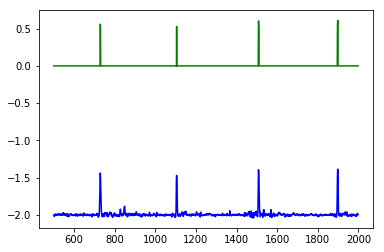

In [59]:
t = range(nbatches*batchSize_rnn*seql_rnn*ninputs)
plt.plot(t[500:2000],predictions1D[500:2000]-2,'b',t[500:2000],peaks[500:2000],'g')

## Compare predicted peaks with annotations

We now compare our predicted peaks (after postprocessing) with the labelled peaks to determine the number of peaks correctly classified by our network.

In [58]:
comparitor = compare_annotations(targets_peak_locs_above_th, peak_locs_above_th, 5, signal=None)
comparitor.print_summary()

11934 reference annotations, 7743 test annotations

True Positives (matched samples): 7731
False Positives (unmatched test samples: 12
False Negatives (unmatched reference samples): 4203

Specificity: 0.6478 (7731/11934)
Positive Predictivity: 0.9985 (7731/7743)
False Positive Rate: 0.0015 (12/7743)


# Feedforward network

The architecture of the Feedforward network is designed below, similarly to what was done for the RNN.

In [67]:
ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(512, activation='relu',input_shape=(2*seqL*ninputs,)))
ffwdModel.add(layers.Dense(256, activation='relu'))
ffwdModel.add(layers.Dense(256, activation='relu'))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL*ninputs))

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData,  epochs=15, steps_per_epoch=2000, validation_data=valData, validation_steps=100)

Epoch 1/15
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0156 - mean_absolute_error: 0.0333 - val_loss: 0.0156 - val_mean_absolute_error: 0.0307
Epoch 2/15
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0154 - mean_absolute_error: 0.0356 - val_loss: 0.0157 - val_mean_absolute_error: 0.0317
Epoch 3/15
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0152 - mean_absolute_error: 0.0368 - val_loss: 0.0157 - val_mean_absolute_error: 0.0317
Epoch 4/15
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0151 - mean_absolute_error: 0.0376 - val_loss: 0.0157 - val_mean_absolute_error: 0.0322
Epoch 5/15
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0151 - mean_absolute_error: 0.0380 - val_loss: 0.0157 - val_mean_absolute_error: 0.0311
Epoch 6/15
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0150 - mean_absolute_error: 0.0381 - val_loss: 0.0157 - val_mean_absolute_error: 0.0346
Epoc

In [0]:
ffwd_weights_file_path = weights_path + 'FFWD_weights.h5'

In [0]:
# Saving the network weights
ffwdModel.save_weights(ffwd_weights_file_path)

In [0]:
ffwdModel.load_weights(ffwd_weights_file_path)

## Predict - FFWD

This process is analog to what was done for the RNN.

In [74]:
ffwd_predictions, ffwd_targets = get_preds_targets(testData, ffwdModel,nbatches)
ffwd_targets1D = np.reshape(ffwd_targets,(nbatches*batchSize*seqL * ninputs))
ffwd_predictions1D = np.reshape(ffwd_predictions,(nbatches*batchSize*seqL * ninputs))

Getting batch 0
Getting batch 1
Getting batch 2
Getting batch 3
Getting batch 4
Getting batch 5
Getting batch 6
Getting batch 7
Getting batch 8
Getting batch 9
Getting batch 10
Getting batch 11
Getting batch 12
Getting batch 13
Getting batch 14
Getting batch 15
Getting batch 16
Getting batch 17
Getting batch 18
Getting batch 19
Getting batch 20
Getting batch 21
Getting batch 22
Getting batch 23
Getting batch 24
Getting batch 25
Getting batch 26
Getting batch 27
Getting batch 28
Getting batch 29
Getting batch 30
Getting batch 31
Getting batch 32
Getting batch 33
Getting batch 34
Getting batch 35
Getting batch 36
Getting batch 37
Getting batch 38
Getting batch 39
Getting batch 40
Getting batch 41
Getting batch 42
Getting batch 43
Getting batch 44
Getting batch 45
Getting batch 46
Getting batch 47
Getting batch 48
Getting batch 49
Getting batch 50
Getting batch 51
Getting batch 52
Getting batch 53
Getting batch 54
Getting batch 55
Getting batch 56
Getting batch 57
Getting batch 58
Getting

## Posprocessing

Postprocessing of the predicted peaks.

In [75]:
ffwd_peak_locs_above_th, ffwd_targets_peak_locs_above_th, ffwd_peaks = get_peaks(ffwd_predictions1D,ffwd_targets1D)
ffwd_peak_locs_above_th

array([    879,    4145,   13276,   15266,   19158,   33312,   38516,
         42312,   54567,   62394,   67316,   69594,   73270,   78076,
         82258,   84058,  100158,  112759,  116355,  120058,  128516,
        137994,  148479,  151767,  154025,  159412,  161358,  167967,
        179066,  180567,  186425,  195740,  198716,  205894,  226025,
        229479,  234716,  238794,  240558,  247229,  258094,  258658,
        262025,  263429,  276412,  278458,  281494,  287112,  301167,
        303312,  303594,  315676,  326516,  328316,  328868,  335367,
        339554,  341225,  347903,  350394,  353679,  362994,  371345,
        378676,  394829,  395394,  403916,  407516,  408068,  422458,
        423567,  425825,  432545,  445858,  452994,  454794,  456740,
        461825,  467540,  470516,  471068,  473903,  479994,  483670,
        484916,  488679,  511876,  546238,  571103,  573279,  573559,
        574780,  580889,  587345,  609412,  629489,  631194,  635980,
        641679,  645

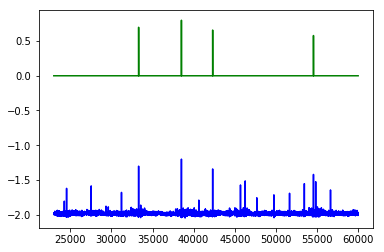

In [76]:
ffwd_t = range(nbatches*batchSize*seqL*ninputs)
plt.plot(ffwd_t[23000:60000],ffwd_predictions1D[23000:60000]-2,'b',ffwd_t[23000:60000],ffwd_peaks[23000:60000],'g')

## Compare predicted peaks with annotations

In [77]:
ffwd_comparitor = compare_annotations(ffwd_targets_peak_locs_above_th, ffwd_peak_locs_above_th, 5, signal=None)
ffwd_comparitor.print_summary()

5346 reference annotations, 219 test annotations

True Positives (matched samples): 190
False Positives (unmatched test samples: 29
False Negatives (unmatched reference samples): 5156

Specificity: 0.0355 (190/5346)
Positive Predictivity: 0.8676 (190/219)
False Positive Rate: 0.1324 (29/219)
